In [6]:
# Loading the data from the processed files :)
import json
import numpy as np
from torch.utils import data
import h5py
import torch
from example.trainer import TrainerWassersteinNormalizedAutoEncoder
from example.loader import Loader
from example.architectures import Encoder, Decoder

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
batch_size = 1024

f = h5py.File("./data/newdata/Data.h5","r")
x_train = f["Background_data"]["Train"]["DATA"][:]
x_test = f["Background_data"]["Test"]["DATA"][:]
x_sig = f["Signal_data"]["GluGluHToBB_M-125"]["DATA"][:]

scale = f["Normalisation"]["norm_scale"][:]
bias = f["Normalisation"]["norm_bias"][:]

data_config = json.loads(f.attrs["config"])
constituents = data_config["Read_configs"]["BACKGROUND"]["constituents"]

x_train = torch.tensor(np.reshape(x_train,(x_train.shape[0],-1))).to(torch.float32).to(device)
x_test = torch.tensor(np.reshape(x_test,(x_test.shape[0],-1))).to(torch.float32).to(device)
x_sig = torch.tensor(np.reshape(x_sig,(x_sig.shape[0],-1))).to(torch.float32).to(device)

train_loader = data.DataLoader(
            dataset=data.TensorDataset(x_train),
            batch_size=batch_size,
        )

val_loader = data.DataLoader(
            dataset=data.TensorDataset(x_test),
            batch_size=batch_size,
        )

val_loader_no_batch = data.DataLoader(
    dataset=data.TensorDataset(x_test),
    batch_size=len(x_train),
)

sig_loader = data.DataLoader(
            dataset=data.TensorDataset(x_sig),
            batch_size=batch_size,
        )

In [7]:
from importlib import import_module

class MyLoader():
    def __init__(self, train_loader, val_loader, val_loader_no_batch, ood_loader) -> None:
        self.training_loader = train_loader
        self.validation_loader = val_loader
        self.validation_loader_no_batch = val_loader_no_batch
        self.ood_loader = ood_loader
        
loaders = MyLoader(train_loader, val_loader, val_loader_no_batch, sig_loader)

config = import_module("example.config")

In [3]:
config.training_params["learning_rate"]

0.0005

In [8]:
input_size = x_train.shape[-1]
intermediate_architecture_encoder = (28,15)
intermediate_architecture_decoder = (24, 32, 64, 128, 57)
bottleneck_size = 8
output_path = "./temp"

encoder = Encoder(
    input_size=input_size,
    intermediate_architecture=intermediate_architecture_encoder,
    bottleneck_size=bottleneck_size,
    drop_out=None,
)
decoder = Decoder(
    output_size=input_size,
    intermediate_architecture=intermediate_architecture_decoder,
    bottleneck_size=bottleneck_size,
    drop_out=None,
)

trainer = TrainerWassersteinNormalizedAutoEncoder(
    config=config,
    loader=loaders,
    encoder=encoder,
    decoder=decoder,
    device=device,
    output_path=output_path,
    loss_function="wnae",  # can change to "ae" or "nae"
)


In [15]:
trainer.train()

[INFO] Starting model fitting
[INFO] 
Epoch 22/80 Training
100%|██████████| 2969/2969 [07:41<00:00]
[INFO] 
Epoch 22/80 Background Evaluation
100%|██████████| 2903/2903 [06:08<00:00]
[INFO] 
Epoch 22/80 OOD Evaluation
[INFO] 834.35 s/epoch - loss: 61.017 - validation loss: 61.265
[INFO] Validation loss improved from inf to 61.265. Saving checkpoint.
[INFO] Saved model checkpoint ./temp/best.pt
[INFO] 
Epoch 23/80 Training
100%|██████████| 2969/2969 [07:25<00:00]
[INFO] 
Epoch 23/80 Background Evaluation
100%|██████████| 2903/2903 [05:57<00:00]
[INFO] 
Epoch 23/80 OOD Evaluation
[INFO] 806.54 s/epoch - loss: 63.250 - validation loss: 62.795
[INFO] 
Epoch 24/80 Training
100%|██████████| 2969/2969 [07:20<00:00]
[INFO] 
Epoch 24/80 Background Evaluation
100%|██████████| 2903/2903 [06:03<00:00]
[INFO] 
Epoch 24/80 OOD Evaluation
[INFO] 807.62 s/epoch - loss: 62.027 - validation loss: 62.641
[INFO] 
Epoch 25/80 Training
100%|██████████| 2969/2969 [07:18<00:00]
[INFO] 
Epoch 25/80 Background 

KeyboardInterrupt: 

In [26]:
# trainer._TrainerWassersteinNormalizedAutoEncoder__save_model_checkpoint("current")

[INFO] Saved model checkpoint ./temp/current.pt


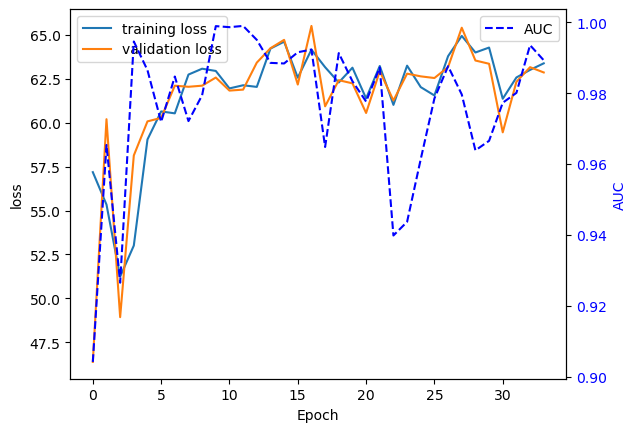

In [16]:
import matplotlib.pyplot as plt
# plt.plot(trainer.metrics_tracker["training_loss"], label="training loss")
# plt.plot(trainer.metrics_tracker["validation_loss"], label="validation loss")
# plt.legend()
# plt.show()
# plt.plot(trainer.metrics_tracker["auc"])

fig, ax1 = plt.subplots()

x_axis = list(range(len(trainer.metrics_tracker["training_loss"])))
# Plot the first dataset on the left y-axis
ax1.plot(x_axis,trainer.metrics_tracker["training_loss"], label="training loss")
ax1.plot(x_axis,trainer.metrics_tracker["validation_loss"], label="validation loss")
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the second dataset on the right y-axis
ax2.plot(x_axis, trainer.metrics_tracker["auc"], 'b--', label='AUC')
ax2.set_ylabel('AUC', color='b')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend()
plt.show()

In [45]:
trainer.metrics_tracker["training_loss"]

[]

# Evaluation

In [7]:
from wnae import WNAE
from plot_util import calc_loss, calc_sig_loss, plot_sig_loss, plot_loss

def loss_mse(target, predicted):
    mse_loss = torch.mean((predicted - target).pow(2), dim=1)
    return mse_loss

model = WNAE(
            encoder=trainer.model.encoder,
            decoder=trainer.model.decoder,
            **config.training_params["wnae_parameters"],
        )
model = model.to(device)

signal_data = f["Signal_data"]

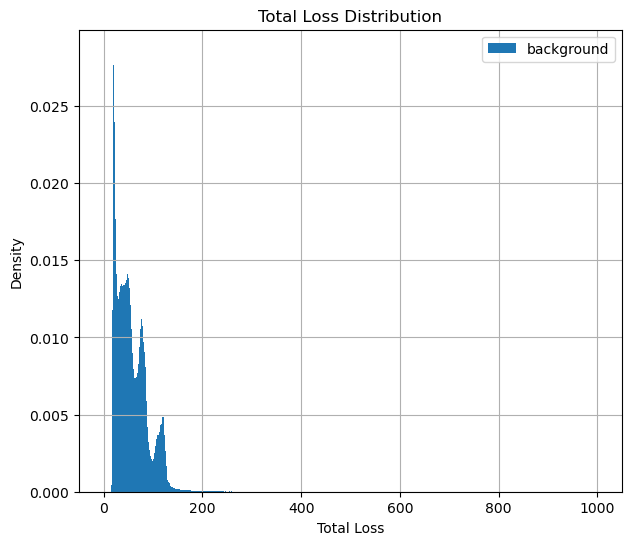

In [35]:
def calc_loss(model, data, loss_func):
    data = torch.reshape(data, (data.shape[0],-1))
    prediction_outputs = model(data, score_method="mse")
    loss = prediction_outputs.detach().numpy()
    # return loss_func(data, prediction_outputs)
    return loss

score_bkg = calc_loss(model, x_test, loss_mse)
plot_loss(score_bkg, 
               bins=np.arange(0, 1000, 0.5), 
              )

plot threshold lines in background plot
match architecture

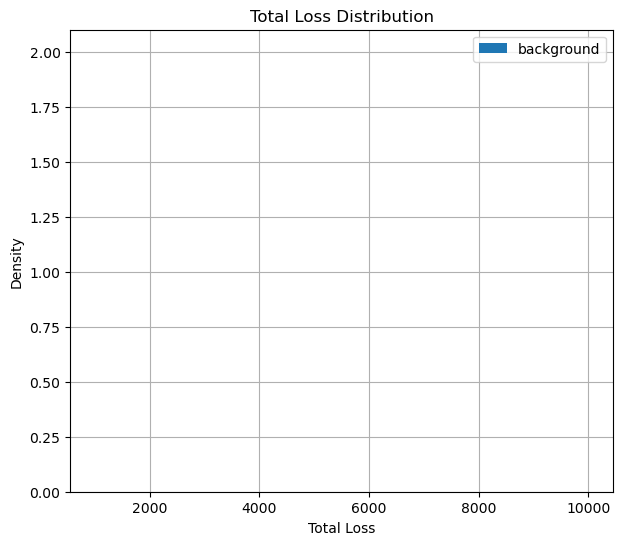

In [30]:
plot_loss(score_bkg, 
               bins=np.arange(1000, 10000, 0.5), 
              )

In [10]:
def calc_sig_loss(model, data, loss_func):
    sig_loss = {}
    for key in data.keys():
        sig = torch.tensor(data[key]['DATA'][:]).to(torch.float32)
        sig = sig.reshape(sig.shape[0], -1)
        loss = model(sig, score_method="mae")
        sig_loss[key] = loss.detach().numpy()
    return sig_loss

loss_sig = calc_sig_loss(model, signal_data, loss_mse)

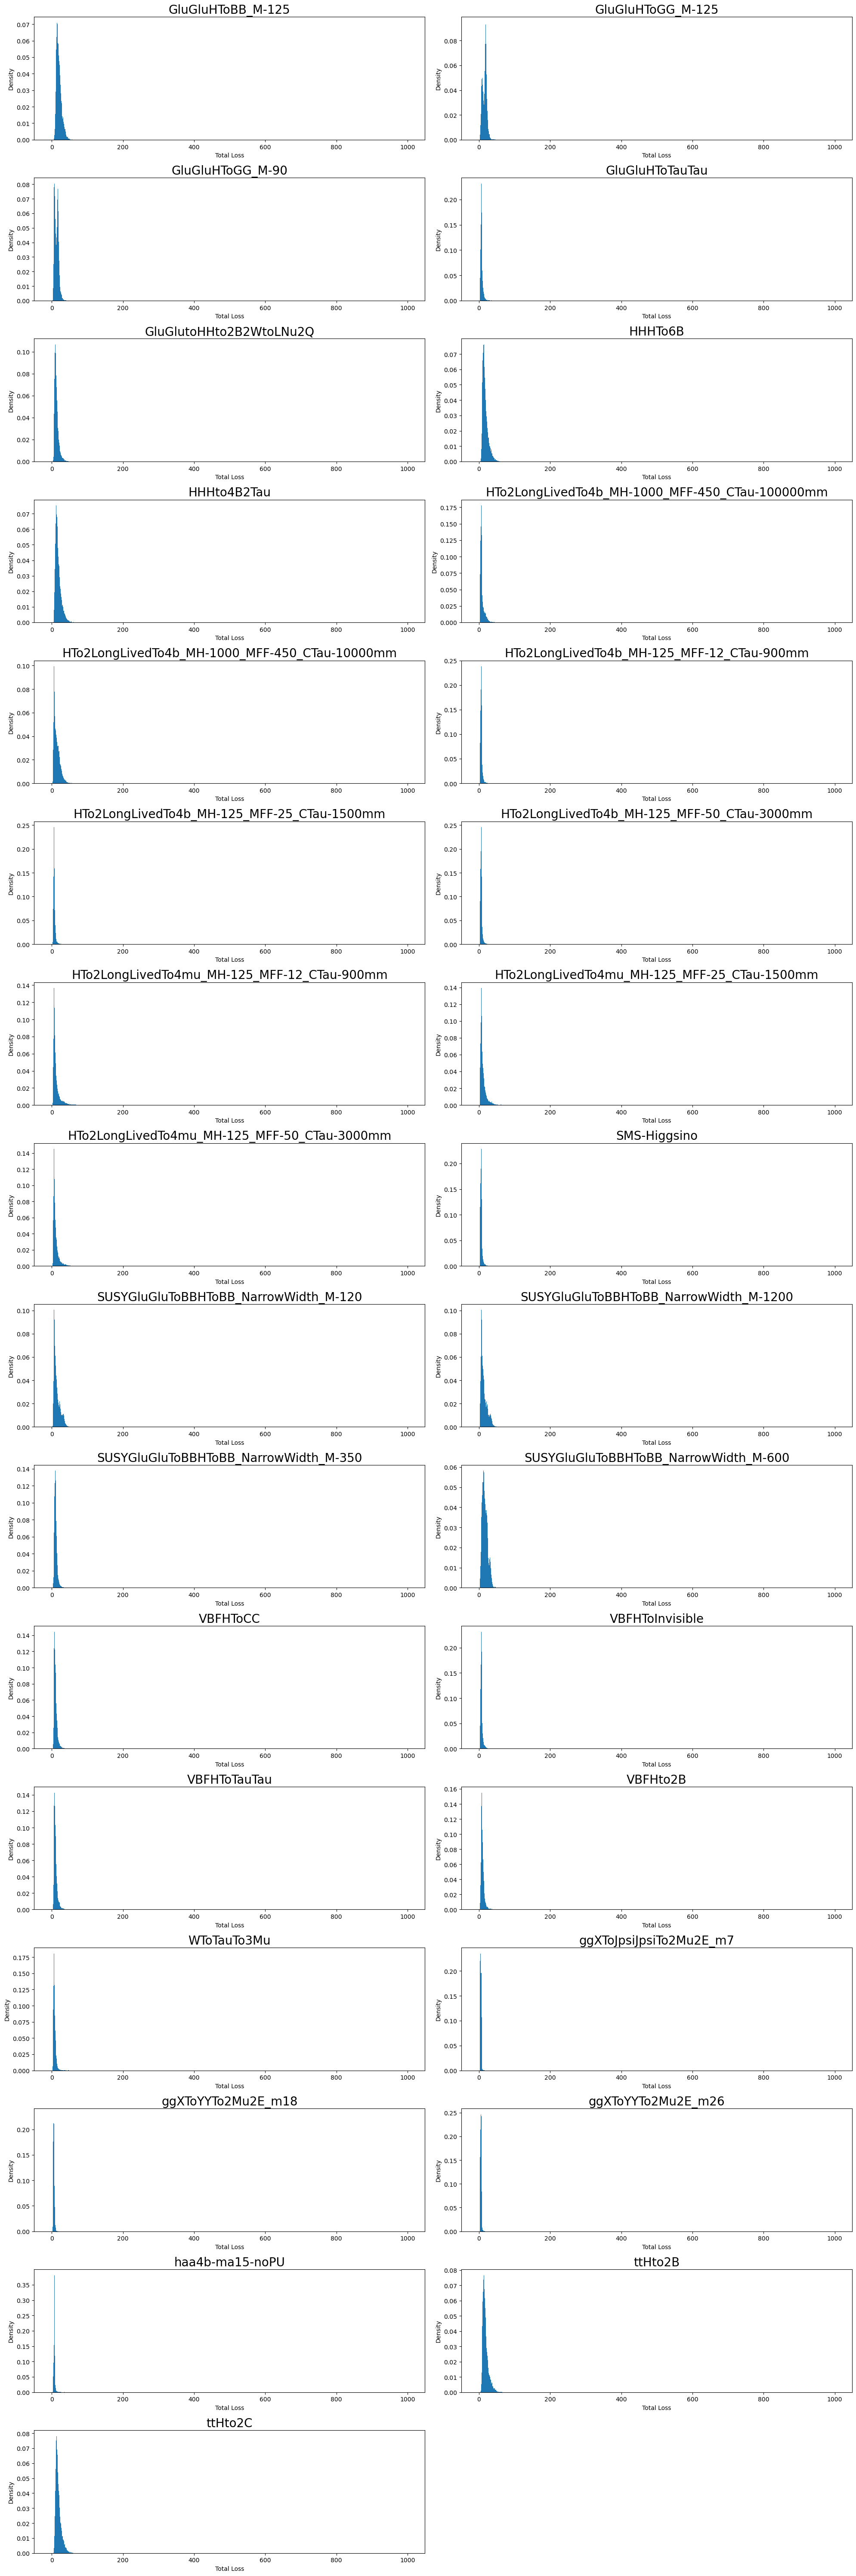

In [11]:
plot_sig_loss(loss_sig, 
                bins=np.arange(0, 1000, 1),
            )

In [27]:
import yaml
import os
import metric
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import json
import torch

# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
# from tensorflow.keras.models import Sequential, Model
# import tensorflow as tf
# from qkeras import quantized_bits

class model_threshold_manager():
    def __init__(self,model, loss_func, config, score_method="mse"):#trimmed_model, loss_func, config):
        self.config = config
        self.model = model
        # self.trimmed_model = trimmed_model
        
        self.target_rate = self.config["target_rate"]
        self.threshold = None
        self.bc_rate_khz = self.config["bc_khz"]
        
        self.score_dict = {} #Internal variable not to be accessed directly
        self.data_file = None #Internal variable not to be accessed directly
        
        self.data_path = self.config["data_path"]
        self.HT_THRESHOLD = self.config["ht_threshold"]

        self.loss_func = loss_func
        self.score_method = score_method
        
        # Init ...
        self._open_hdf5()
        ap_fixed = self.config["precision"]
        # self.input_quantizer = quantized_bits(ap_fixed[0],ap_fixed[1],alpha=self.config["alpha"])
        print("Calculating Threshold...")
        self.get_threshold()
        print("Evaluating Score for model...")
        self.calculate_score()
        print("DONE")
        
    def _open_hdf5(self):
        self.data_file = h5py.File(self.data_path,"r")
    
    def get_threshold(self):
        x_test = self.data_file["Background_data"]["Test"]["DATA"][:]
        x_test = torch.tensor(np.reshape(x_test,(x_test.shape[0],-1))).to(torch.float32)       

        #claculate bkg score for full model
        # x_reco, z_mean, z_log_var= self.full_model.predict(self.input_quantizer(x_test),batch_size = 120000)
        # y_loss = self.loss_func(x_test, x_reco, z_mean, z_log_var)

        prediction_outputs = self.model(x_test, score_method = self.score_method)
        # if isinstance(prediction_outputs, list):
        #     prediction_outputs = tuple(prediction_outputs)
        # if not isinstance(prediction_outputs, tuple):
        #         prediction_outputs = (prediction_outputs,)
        # y_loss = self.loss_func(self.input_quantizer(x_test), *prediction_outputs)
        global y_loss
        y_loss = prediction_outputs.detach().numpy()
        
        
        
        # #Calculate bkg score for trimmed model
        # latent_axo_qk = self.trimmed_model.predict(self.input_quantizer(x_test),batch_size = 120000)
        # y_axo_qk = np.sum(latent_axo_qk**2, axis=1)
        print(sorted(y_loss)[-10:])
        
        threshold = {}
        # full_threshold = {}
        # axo_threshold = {}
        #Calculate threshold for each rate
        for target_rate in self.target_rate: 
            #converts from rate to percentile using predetermined hardware rate
            print("threshold percentile: ", 100-(target_rate/self.bc_rate_khz)*100)
            threshold[str(target_rate)] = np.percentile(y_loss, 100-(target_rate/self.bc_rate_khz)*100) 
            # threshold[str(target_rate)] = np.percentile(y_axo_qk, 100-(target_rate/self.bc_rate_khz)*100)
        # threshold['full'] = full_threshold
        # threshold['axo'] = axo_threshold
        self.threshold = threshold #Store threshold as dictionary of thresholds for the full and trimmed model

    def calculate_score(self):
        HT_THRESHOLD = self.HT_THRESHOLD
        signal_names = list(self.data_file["Signal_data"].keys())
        score = {}
        score["SIGNAL_NAMES"] = signal_names
        score["SCORE"] = {}
        for target_rate in self.target_rate:
            _raw_rate = [] #Rate/efficiency for model
            # _raw_axo_rate = [] #rate/efficiency for trimmed model
            _l1_rate = [] #rate/efficiency for l1 trigger
            _ht_rate = []
            _model_improv_rate = []
            for signal in signal_names:
                signal_data = self.data_file["Signal_data"][signal]["DATA"][:]
                signal_data = torch.tensor(np.reshape(signal_data,(signal_data.shape[0],-1))).to(torch.float32)
                signal_ET = self.data_file["Signal_data"][signal]["ET"][:]
                signal_HT = self.data_file["Signal_data"][signal]["HT"][:]
                signal_L1 = self.data_file["Signal_data"][signal]["L1bits"][:]
                signal_PU = self.data_file["Signal_data"][signal]["PU"][:]

                #Calc sig score for full model
                # signal_reco, z_mean, z_log_var = self.full_model.predict(self.input_quantizer(signal_data),batch_size = signal_data.shape[0],verbose=0)
                # signal_loss = self.loss_func(signal_data, signal_reco, z_mean, z_log_var)
                prediction_outputs = self.model(signal_data, score_method=self.score_method)
                # if isinstance(prediction_outputs, list):
                #     prediction_outputs = tuple(prediction_outputs)
                # if not isinstance(prediction_outputs, tuple):
                #         prediction_outputs = (prediction_outputs,)
                # signal_loss = self.loss_func(self.input_quantizer(signal_data), *prediction_outputs)
                
                signal_loss = prediction_outputs.detach().numpy()
                
                # #Calc signal score for trimmed model
                # latent_axo_qk = self.trimmed_model.predict(self.input_quantizer(signal_data),batch_size = signal_data.shape[0],verbose=0)
                # y_axo_qk = np.sum(latent_axo_qk**2, axis=1)

                nsamples = signal_data.shape[0]

                model_triggered = np.where(signal_loss > self.threshold[str(target_rate)])[0].tolist()
                # axo_triggered = np.where(y_axo_qk > self.threshold['axo'][str(target_rate)])[0].tolist()
                l1_triggered = np.where(signal_L1)[0].tolist()
                ht_triggered = np.where(signal_HT > HT_THRESHOLD)[0].tolist()

                raw_rate = len(model_triggered)/nsamples
                # raw_rate = len(axo_triggered)/nsamples
                l1_rate = len(l1_triggered)/nsamples
                ht_rate = len(ht_triggered)/nsamples

                model_improv = list(set(model_triggered)-set(l1_triggered))
                model_improv_rate = len(model_improv)/nsamples

                _raw_rate.append(raw_rate)
                _l1_rate.append(l1_rate)
                # _raw_axo_rate.append(raw_rate)
                _model_improv_rate.append(model_improv_rate)
                _ht_rate.append(ht_rate)

            score["SCORE"][str(target_rate)] = {
                "model_rate": _raw_rate,
                # "raw-axo":_raw_axo_rate,
                "L1_rate":_l1_rate,
                "HT_rate":_ht_rate,
                "model_improvement":_model_improv_rate,
            }

        self.score_dict = score ## Storing it here
        
    def get_raw_dict(self):
        return self.score_dict,self.threshold
    def get_score(self,thres, axo_scores=None, vae_model_scores=None):
        signal_names = self.data_file["Signal_data"].keys()
        df = pd.DataFrame()
        df["Signal Name"] = signal_names
        df['MODEL SCORE'] = self.score_dict["SCORE"][str(thres)]['model_rate']
        # df["AXO SCORE"] = axo_scores
        # df["VAE SCORE"] = vae_model_scores
        df["L1 SCORE"] = self.score_dict["SCORE"][str(thres)]['L1_rate']
        df["HT SCORE"] = self.score_dict["SCORE"][str(thres)]['HT_rate']
        df["MODEL Improvement"] = self.score_dict["SCORE"][str(thres)]['model_improvement']
        
        return df
    
config_thres = yaml.load(open("./utilities/config.yml","r"), Loader=yaml.Loader)
model_man_mse = model_threshold_manager(model=model,
                              loss_func=loss_mse,
                              config=config_thres['threshold'],
                              score_method="mse"
                              )

model_man_mae = model_threshold_manager(model=model,
                              loss_func=loss_mse,
                              config=config_thres['threshold'],
                              score_method="mae"
                              )

Calculating Threshold...
[2042.8468, 2194.6558, 2294.5347, 2384.254, 2448.524, 2662.476, 2668.386, 2915.9482, 3061.0708, 3391.9514]
threshold percentile:  99.99947568592026
threshold percentile:  99.99930091456035
threshold percentile:  99.99895137184052
threshold percentile:  99.99790274368105
threshold percentile:  99.99650457280175
threshold percentile:  99.99300914560351
threshold percentile:  99.98951371840525
threshold percentile:  99.98252286400876
threshold percentile:  99.96504572801751
Evaluating Score for model...
DONE
Calculating Threshold...
[31.322592, 32.605858, 33.082363, 33.76948, 34.319725, 35.710957, 35.726295, 37.16012, 37.95675, 40.139435]
threshold percentile:  99.99947568592026
threshold percentile:  99.99930091456035
threshold percentile:  99.99895137184052
threshold percentile:  99.99790274368105
threshold percentile:  99.99650457280175
threshold percentile:  99.99300914560351
threshold percentile:  99.98951371840525
threshold percentile:  99.98252286400876
thr

In [23]:
print(sum(y_loss > 31))
print(len(y_loss))

10
2972127


In [24]:
import pandas as pd
file_path = "../MAE_performance.xlsx"

all_sheets = pd.read_excel(file_path, sheet_name=None)

axo_mae_scores = {}
vae_mae_model_scores = {}
for sheet_name, df in all_sheets.items():
    print(f"Sheet name: {sheet_name}")
    for idx, score in enumerate(df["MODEL SCORE"]):
        vae_mae_model_scores[idx] = vae_mae_model_scores.get(idx, list())
        vae_mae_model_scores[idx].append(score)
        
    for idx, score in enumerate(df["axo_score"]):
        axo_mae_scores[idx] = axo_mae_scores.get(idx, list())
        axo_mae_scores[idx].append(score)

Sheet name: 0.15kHz
Sheet name: 0.2kHz
Sheet name: 0.3kHz
Sheet name: 0.6kHz
Sheet name: 1kHz
Sheet name: 2kHz
Sheet name: 3kHz
Sheet name: 5kHz
Sheet name: 10kHz


In [25]:
import pandas as pd
file_path = "../mse_performance.xlsx"

all_sheets = pd.read_excel(file_path, sheet_name=None)

axo_mse_scores = {}
vae_mse_model_scores = {}
for sheet_name, df in all_sheets.items():
    print(f"Sheet name: {sheet_name}")
    for idx, score in enumerate(df["MODEL SCORE"]):
        vae_mse_model_scores[idx] = vae_mse_model_scores.get(idx, list())
        vae_mse_model_scores[idx].append(score)
        
    for idx, score in enumerate(df["axo_score"]):
        axo_mse_scores[idx] = axo_mse_scores.get(idx, list())
        axo_mse_scores[idx].append(score)

Sheet name: 0.15kHz
Sheet name: 0.2kHz
Sheet name: 0.3kHz
Sheet name: 0.6kHz
Sheet name: 1kHz
Sheet name: 2kHz
Sheet name: 3kHz
Sheet name: 5kHz
Sheet name: 10kHz


/var/folders/cr/lf3ftc1562j666v_rns8jtc00000gn/T/ipykernel_34278/2337836049.py:66: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,1)


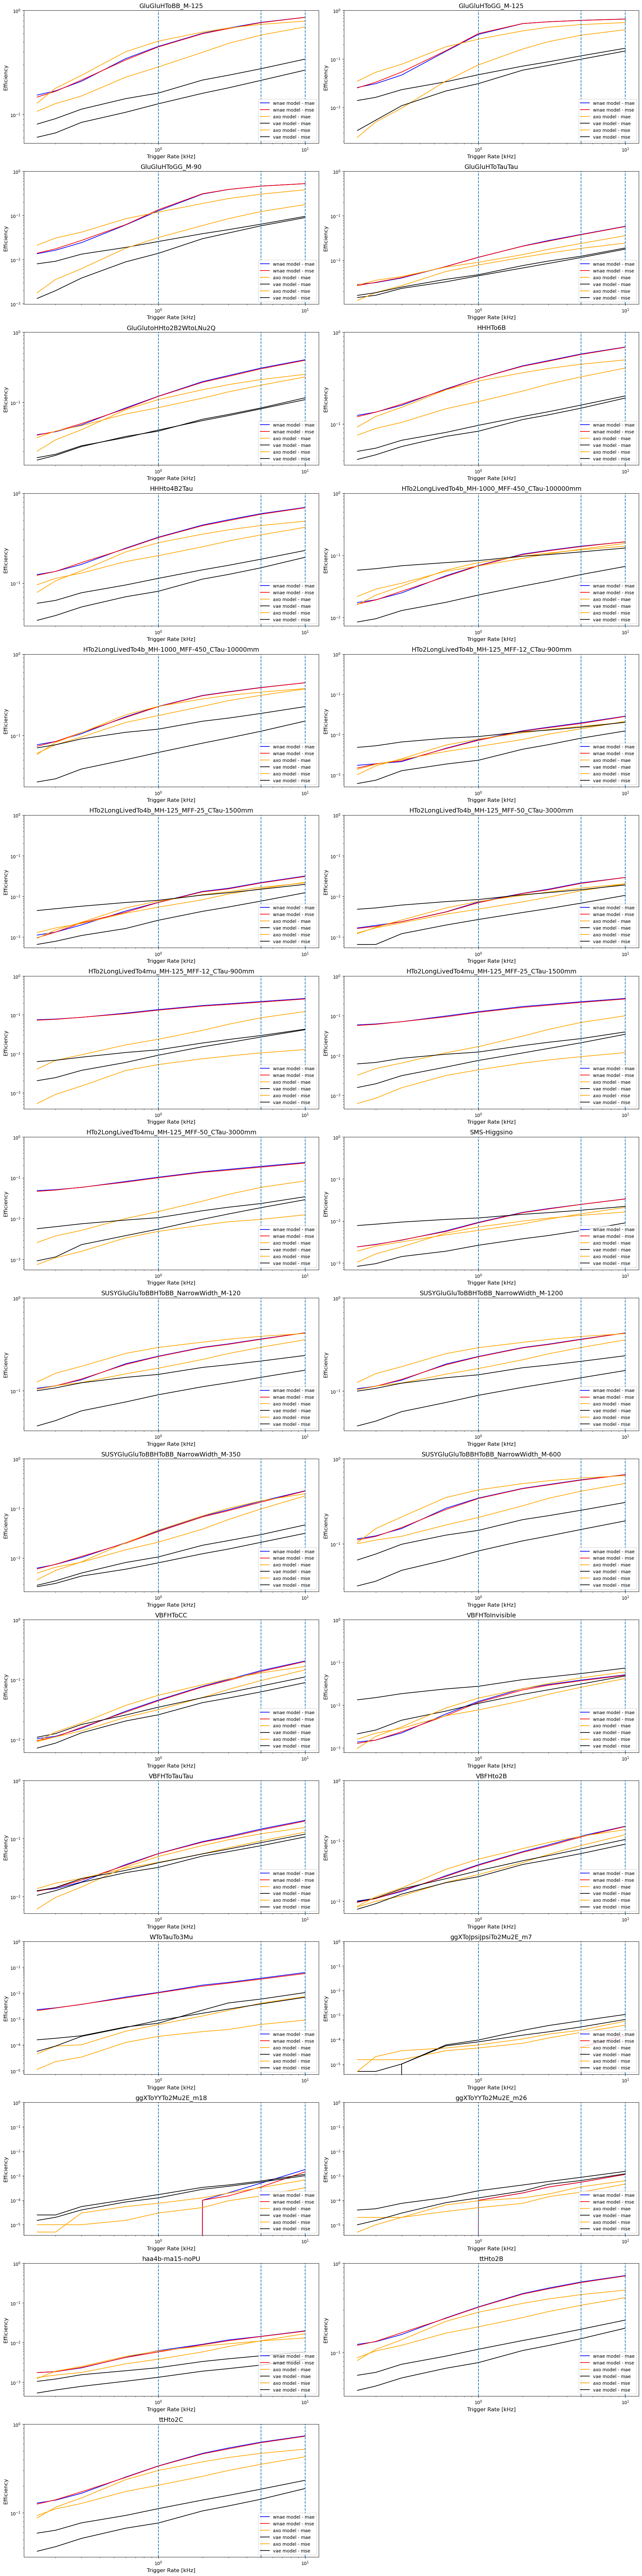

In [31]:
import matplotlib.pyplot as plt
score_dict_mse, thresholds= model_man_mse.get_raw_dict()
score_dict_mae, thresholds= model_man_mae.get_raw_dict()

signal_names = list(score_dict_mse['SIGNAL_NAMES'])
model_score_mse = score_dict_mse['SCORE']
model_score_mae = score_dict_mae['SCORE']
model_rates = list(model_score_mse.keys())
# trimmed_score = score_dict_trim['SCORE']
# trimmed_rates = list(trimmed_score.keys())
wnae_model_scores_mse = {}
wnae_model_scores_mae = {}

num_plots = len(signal_names)
fig, axes = plt.subplots(nrows=int(np.ceil(num_plots / 2)), 
                         ncols=2, 
                         figsize=(20, 80))
axes = axes.flatten()

for ax in axes[num_plots:]:
    ax.axis('off')
        
for i in range(len(signal_names)):
    ax = axes[i]
    full_score_mse = np.array([])
    full_score_mae = np.array([])

    # trim_score = np.array([])
    for rate in model_rates:
#         print(score[rate]['raw-axo'])#['full_model'][0])
        full_score_mse = np.append(full_score_mse, model_score_mse[rate]['model_rate'][i])
        full_score_mae = np.append(full_score_mae, model_score_mae[rate]['model_rate'][i])
        # trim_score = np.append(trim_score, trimmed_score[rate]['model_rate'][i])
        
    wnae_model_scores_mse[i] = full_score_mse
    wnae_model_scores_mae[i] = full_score_mae
    
    axo_mae_score = np.array(axo_mae_scores[i])
    vae_mae_model_score = np.array(vae_mae_model_scores[i])
    axo_mse_score = np.array(axo_mse_scores[i])
    vae_mse_model_score = np.array(vae_mse_model_scores[i])
    
    rates_int = [float(rate) for rate in model_rates]
    ax.plot(rates_int, full_score_mae, label='wnae model - mae', color='blue')
    ax.plot(rates_int, full_score_mse, label='wnae model - mse', color='red')
    
    ax.plot(rates_int, axo_mae_score, label='axo model - mae', color='orange')
    ax.plot(rates_int, vae_mae_model_score, label='vae model - mae', color='black')
    ax.plot(rates_int, axo_mse_score, label='axo model - mse', color='orange')
    ax.plot(rates_int, vae_mse_model_score, label='vae model - mse', color='black')
    
    # ax.plot(rates_int, trim_score, label='trimmed model', color='orange')

    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlim(rates_int[0], rates_int[-1])

    ax.set_xlabel("Trigger Rate [kHz]", fontsize=12)
    ax.set_ylabel('Efficiency', fontsize=12)
    
    ax.set_title(signal_names[i], fontsize=14)
    ax.legend(loc='lower right', fontsize=10)
    ax.axvline(x=1, linestyle='--')
    ax.axvline(x=5, linestyle='--')
    ax.axvline(x=10, linestyle='--')
    ax.set_ylim(0,1)

plt.tight_layout()
# plt.savefig('./figures/signal_eff_plots_orig_results.png')
plt.show()

In [34]:
rate = 10
df = model_man_mae.get_score(rate)
# df['axo_score'] = trimmed_man.get_score(rate)['MODEL SCORE']
df

,Signal Name,MODEL SCORE,L1 SCORE,HT SCORE,MODEL Improvement
0,GluGluHToBB_M-125,0.859651,0.992977,0.994846,0.001359
1,GluGluHToGG_M-125,0.666701,0.884231,0.677413,0.003914
2,GluGluHToGG_M-90,0.527426,0.807127,0.509989,0.004219
3,GluGluHToTauTau,0.058380,0.400623,0.214480,0.000603
4,GluGlutoHHto2B2WtoLNu2Q,0.406658,0.871617,0.867346,0.002264
5,HHHTo6B,0.691020,0.954173,0.981735,0.001914
6,HHHto4B2Tau,0.695723,0.964662,0.972199,0.001857
7,HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-100000mm,0.165273,0.421763,0.382850,0.000492
8,HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-10000mm,0.445258,0.778469,0.708692,0.000366
9,HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm,0.028770,0.302365,0.200122,0.000304
